In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import itertools
import metodos_labo as labo 

plt.style.use('./informes.mplstyle')

In [ ]:
df = pd.read_csv(f'Mediciones/Clase 3/celda_tvsV_I=1.5.csv')
df2     =   df[(df['Tiempo [s]']>100) & (df['Tiempo [s]']<600)]
t       =   df2['Tiempo [s]'].values
v       =   df2['Tension generador [V]'].values
tf      =   df2['Tensión termocupla fria [V]'].values
tc      =   df2['Tensión termocupla caliente [V]'].values


tf = tf*1e3 #Pasa el valor a mV
tc = tc*1e3

ran_thr = 400 #Rango de medición cuando los valores se encontraba en [-200,200]

errinstr_v = np.zeros(len(v))  # Error instrumental por manual
errinstr_v[v >= ran_thr] = v[v >= ran_thr]*0.0002 + 350*10e-6
errinstr_v[v < ran_thr] = v[v < ran_thr]*0.00015 + 225*10e-6
errinstr_tf = 0.00005*tf + 0.0035 #Error de medición en voltaje de las termocuplas, debido a instrumental
errinstr_tc = 0.00005*tc + 0.0035


cal_c = np.array([22.61920443, 28.0633875])
cov_c = np.array([[0.02231615, -0.02171227],
                  [-0.02171227, 0.03414086]])
tc_bar = [] #Valor de temperatura de cada medición
sigma_tc_bar = [] # Error en la medición de cada temperatura
for i in range(len(tc)):
    tc_bar.append(labo.calibracion_termo(cal_c[0],cal_c[1],tc[i])) #convierto voltaje en temperatura
    valor_medido = tc_bar[i]
    # sigma_valor_medido = np.abs(errinstr_tc[i])
    sigma_valor_medido = np.sqrt(1/(np.sum(1/errinstr_tc**2)))
    cal_c_temporario = np.array([cal_c[0],cal_c[1],valor_medido])
    cov_c_temporario = np.array([[0.02231615 , -0.02171227,0],
                                 [-0.02171227, 0.03414086, 0],
                                 [0          , 0         , sigma_valor_medido]])
    sigma_tc_bar.append(labo.corr_propagation(labo.calibracion_termo, cal_c_temporario, cov_c_temporario))

cal_f = np.array([22.67143206, 28.01350804])  # Calibracion termo fria (2)
cov_f = np.array([[0.02317165, -0.02023376],
                  [-0.02023376, 0.03057282]])

tf_bar = []
sigma_tf_bar = []
for i in range(len(tf)):
    tf_bar.append(labo.calibracion_termo(cal_f[0],cal_f[1],tf[i]))
    valor_medido = tf_bar[i]
    # sigma_valor_medido = np.abs(errinstr_tf[i])
    sigma_valor_medido = np.sqrt(1/(np.sum(1/errinstr_tf**2)))

    cal_f_temporario = np.array([cal_f[0],cal_f[1],valor_medido])
    cov_f_temporario = np.array([[0.02231615, -0.02171227,0],
                                 [-0.02171227, 0.03414086,0],
                                 [0,0,sigma_valor_medido]])
    sigma_tf_bar.append(labo.corr_propagation(labo.calibracion_termo, cal_f_temporario, cov_f_temporario))
tc_bar = np.array(tc_bar)
tf_bar = np.array(tf_bar)

delta_t = tc_bar - tf_bar
sigma_delta_t = []
for i in range(len(delta_t)):

    sigma_delta_t.append(labo.quadsum(sigma_tc_bar[i], sigma_tf_bar[i]))
sigma_delta_t = np.array(sigma_delta_t)
print(np.sqrt(1/(np.sum(1/errinstr_tf**2))))
print(sigma_tf_bar)

# falta:
# errores en delta t (propagación con los errores de las termocuplas)
# errores en v (los del multímetro)
# ajuste (con min cuad)
# ver de seleccionar una parte que parezca lineal + comparar con lo de fische



0.00016096184681380944
[2.980755596505667, 2.9885133477035866, 2.998423914201162, 3.0079103612264855, 3.0184920348547593, 3.026183451047791, 3.0352833738877987, 3.0430089313612676, 3.05143888373309, 3.0592693200934713, 3.0686196175462226, 3.0765549645469634, 3.0861888578493932, 3.0951827890955323, 3.1037928131319146, 3.113319721818121, 3.123059239336704, 3.1324081114144473, 3.1432065018283786, 3.151814467779627, 3.162050627845916, 3.1710467144067604, 3.179904846803629, 3.1894002985717838, 3.1983297065424052, 3.207222269156534, 3.2155858042662677, 3.224552980260215, 3.2326337506017557, 3.2432600622885497, 3.252470690300515, 3.263626927198222, 3.271991803383348, 3.2816988080080733, 3.2905260334496758, 3.2992084800181254, 3.305881457434903, 3.3156972558324393, 3.3241341234932396, 3.3339841165847175, 3.343129560830456, 3.351742392967468, 3.361488544375978, 3.3680917836285165, 3.3763173210078703, 3.3847217764159523, 3.392947655709234, 3.400364243807198, 3.4099328199647108, 3.419784942546901

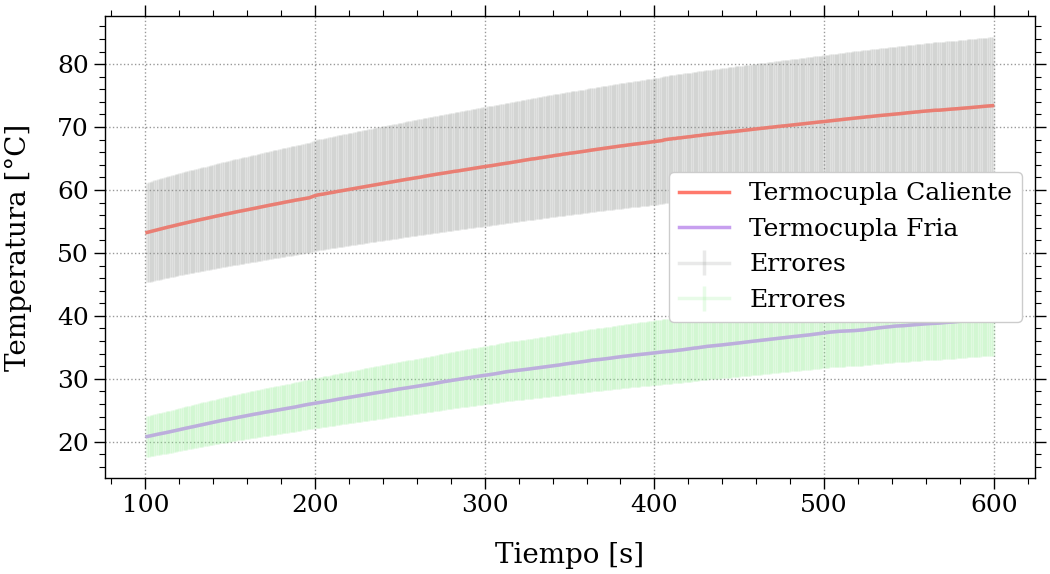

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(t,tc_bar,sigma_tc_bar,label = f'Errores',alpha = 0.2,color = 'C9')
ax.plot(t,tc_bar,color = 'C3',label = f'Termocupla Caliente')
ax.errorbar(t,tf_bar,sigma_tf_bar,label = f'Errores',alpha = 0.2)
ax.plot(t,tf_bar,color = 'C2',label = f'Termocupla Fria')

ax.set_ylabel(f'Temperatura [°C]')
ax.set_xlabel(f'Tiempo [s]')
ax.legend()

Text(0.5, 0, 'Voltaje')

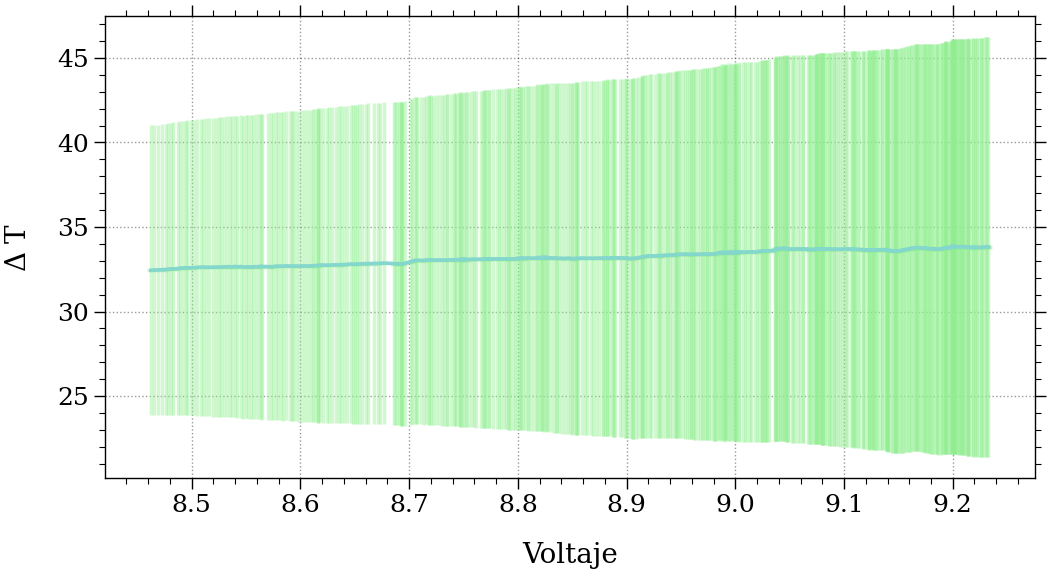

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(v,delta_t,yerr = sigma_delta_t,xerr= errinstr_v,alpha = 0.4)
ax.plot(v,delta_t)
ax.set_ylabel(f'$\Delta$ T')
ax.set_xlabel(f'Voltaje')

$\Delta$ T[0] = 32.44 +- 8.57 


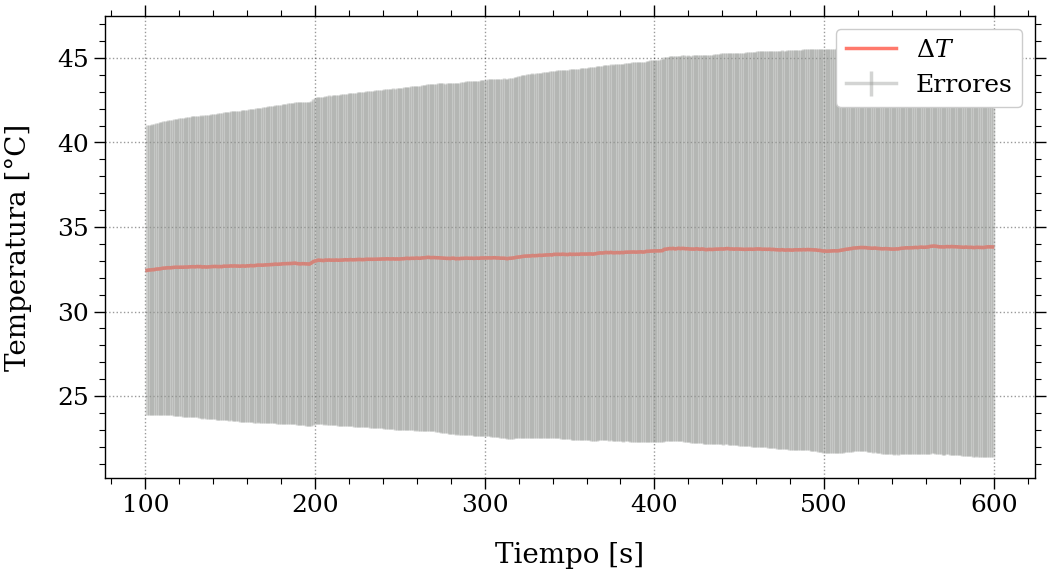

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(t,delta_t,sigma_delta_t,label = f'Errores',alpha = 0.4,color = 'C9')
ax.plot(t,delta_t,color = 'C3',label = f'$\Delta T$')

ax.set_ylabel(f'Temperatura [°C]')
ax.set_xlabel(f'Tiempo [s]')
ax.legend()

print(f'$\Delta$ T[0] = {delta_t[0]:.2f} +- {sigma_delta_t[0]:.2f} ')

R = 0.33 +- 5.96 (Usando Seebeck de ajuste)
R = -20.71 +- 5.96
[ 1.79040452 17.34850536]
0.5585329953080357


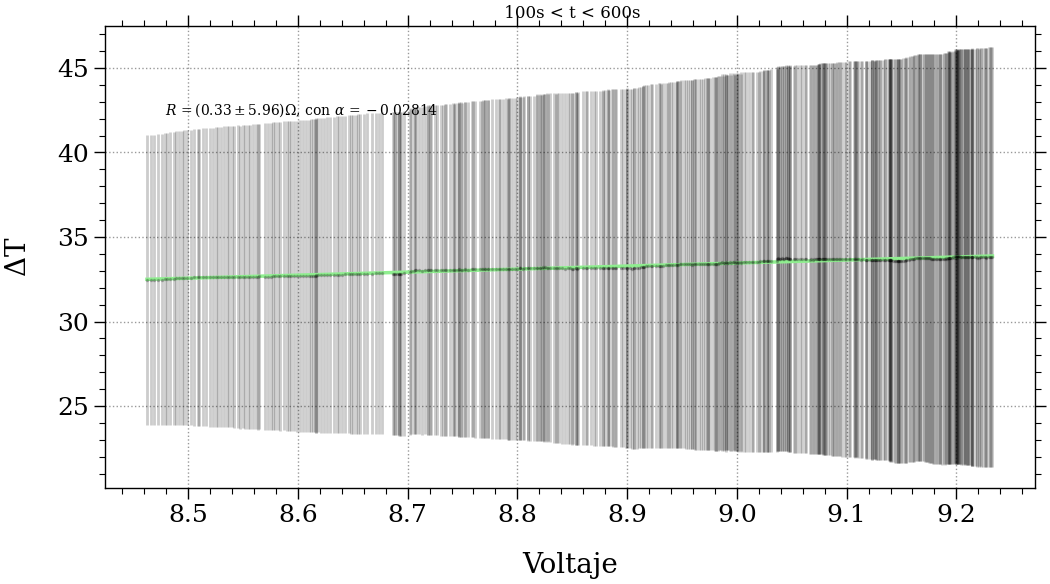

In [ ]:
ajuste_R = lambda V,m,b: m*V + b

popt, pcov, P = labo.least_squares(ajuste_R, v, delta_t, sigma_delta_t)

print(f'R = {(popt[1]*-0.02814)/(-1.5):.2f} +- {np.sqrt(pcov[1][1]):.2f} (Usando Seebeck de ajuste)')
print(f'R = {(popt[1]*popt[0])/(-1.5):.2f} +- {np.sqrt(pcov[1][1]):.2f}')


fig,ax = plt.subplots()

ax.errorbar(v,delta_t,yerr = sigma_delta_t,color='k', lw=2, marker='.', ls='', ms=3, label=f'Datos',alpha = 0.2)
x = np.linspace(v[0],v[-1],len(v))
ax.plot(x,ajuste_R(x,*popt))
ax.set_title(f' 100s < t < 600s')
ax.set_ylabel('$\Delta$T')
ax.set_xlabel(f'Voltaje')
ax.text(v[5],delta_t[5]+delta_t[5]*0.3,rf'$R \, = ({(popt[1]*-0.02814)/(-1.5):.2f}\pm {np.sqrt(pcov[1][1]):.2f})\Omega $, con $\alpha \, = -0.02814$')
print(popt)
print(1/popt[0])


In [ ]:
ajuste_R_2 = lambda T,m,b: m*T + b

popt, pcov, P = labo.least_squares(ajuste_R_2, delta_t, v, errinstr_v)

print(f'R = {(popt[1])/(-1.5):.2f} +- {np.sqrt(pcov[1][1]):.2f}')



fig,ax = plt.subplots()

ax.errorbar(delta_t,v,yerr = errinstr_v,color='k', lw=2, marker='.', ls='', ms=3, label=f'Datos',alpha = 0.2)
x = np.linspace(delta_t[0],delta_t[-1],len(delta_t))
ax.plot(x,ajuste_R_2(x,*popt))
ax.set_title(f' 100s < t < 600s')
ax.set_xlabel('$\Delta$T')
ax.set_ylabel(f'Voltaje')
# ax.text(delta_t[5],v[5]+v[5]*0.3,rf'$R \, = ({(popt[1])/(-1.5):.2f}\pm {np.sqrt(pcov[1][1]):.2f})\Omega $, con $\alpha \, = -0.02814$')


In [ ]:
# una vez que esté coef de seebeck:
# def cuenta_R(v, a, I, delta_t):
#     R = (v-a*delta_t)
#     return R